# Testing Negativ Binomail and Gamma loss Data fitting and parameter estimation within PyGOM

This is an example of parameter fitting with an SIR model.

In [1]:
from pygom import Transition, TransitionType, SimulateOde, SquareLoss, PoissonLoss, NormalLoss, NegBinomLoss, GammaLoss
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import copy

from scipy.optimize import minimize

In [2]:
# Generate some data for fitting

# Standard SIR model with 2 parameters
# construct model 
states = ['S', 'I', 'R']
params = ['beta', 'gamma', 'N']
transitions = [Transition(origin='S', destination='I', equation='beta*S*I/N', 
                          transition_type=TransitionType.T),
               Transition(origin='I', destination='R', equation='gamma*I', 
                          transition_type=TransitionType.T)]
model = SimulateOde(states, params, transition=transitions)

In [3]:
# initial conditions 
N = 1e6
in_inf = 1
init_state = [N - in_inf, in_inf, 0.0]
# time 
t = np.arange (0 , 51 , 0.25)
# deterministic parameter values
param_evals = [('beta', 3.6), ('gamma', 0.2), ('N', N)]
model.parameters = param_evals
model.initial_values = (init_state, t[0])

In [4]:
# run 1 simulations
data = model.integrate(t[1:])

Data over 100 days, with observations from every day for infected and removed populations.

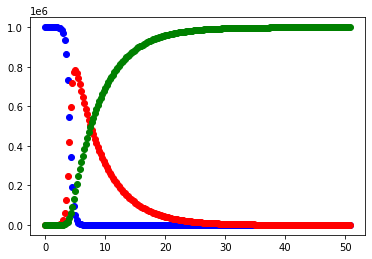

In [5]:
plt.plot(t,data[:,0], 'bo') # infected observations
plt.plot(t,data[:,1], 'ro') # infected observations
plt.plot(t,data[:,2], 'go') # removed observations (recoverd/died)

plt.show()

# Adding random noise to produce Continuos Data

Our data needs to be have some noise so lets put it through a function for randomisation using the gamma distribution.

In [6]:
np.random.seed(42)

In [7]:
def runif_noise(x,noise_prop):
    '''
    Takes x and adds noise on the uniform distribution.
    '''
    i_len,j_len = x.shape
    ans = copy.deepcopy(x)
    for i in range(i_len):
        for j in range(j_len):
            ans[i,j]=x[i,j] + x[i,j]*np.random.uniform(low=-noise_prop,high=noise_prop,size=1)
                   
    return ans

In [8]:
data[0,:]

array([9.99999e+05, 1.00000e+00, 0.00000e+00])

In [9]:
noised_data = runif_noise(data,1/3)
#we stil want the first row from data
noised_data[0,:] = data[0,:]
(noised_data-data)/data

<ipython-input-9-74bf619963ac>:4: RuntimeWarning: invalid value encountered in true_divide
  (noised_data-data)/data


array([[ 0.        ,  0.        ,         nan],
       [ 0.06577232, -0.22932091, -0.22933699],
       [-0.29461093,  0.24411743,  0.06741001],
       [ 0.13871505, -0.31961034,  0.31327323],
       [ 0.22162843, -0.19177393, -0.21211669],
       [-0.21106366, -0.13050517,  0.01650429],
       [-0.04536999, -0.13918057,  0.0745686 ],
       [-0.24033743, -0.13857023, -0.0890921 ],
       [-0.02928668,  0.19011731, -0.20021748],
       [ 0.00948963,  0.06160971, -0.30236639],
       [ 0.07169657, -0.21965058, -0.2899656 ],
       [ 0.29925702,  0.31042136,  0.20559823],
       [-0.13025749, -0.26821859,  0.12282202],
       [-0.03989834, -0.25197451, -0.00321539],
       [-0.31040765,  0.27288027, -0.16081335],
       [ 0.10834819, -0.12552595,  0.01337868],
       [ 0.03114019, -0.21009703,  0.31305642],
       [ 0.18342188,  0.29299929,  0.26321823],
       [ 0.06526665,  0.28124949, -0.27433833],
       [-0.20267809, -0.30318181, -0.11644645],
       [-0.07421514, -0.15243398,  0.219

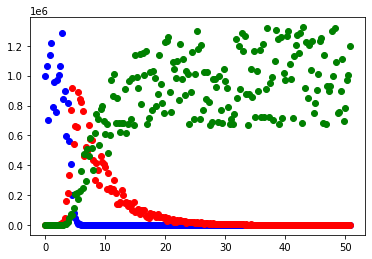

In [10]:
plt.plot(t,noised_data[:,0], 'bo') # infected observations
plt.plot(t,noised_data[:,1], 'ro') # infected observations
plt.plot(t,noised_data[:,2], 'go') # removed observations (recoverd/died)

plt.show()

We provide a guess for $\beta$ and $\gamma$. 

This example assumes we have information about the infected and removed population, up to 50 days of the epidemic.


In [11]:
data_to_fit = noised_data[1::,1:3]
data_to_fit

array([[1.80311437e+00, 6.07303299e-02],
       [6.81020026e+00, 2.80913227e-01],
       [8.71370750e+00, 9.12109018e-01],
       [2.42169873e+01, 1.34235092e+00],
       [6.09515924e+01, 4.13195572e+00],
       [1.41167502e+02, 1.03036634e+01],
       [3.30434916e+02, 2.05046119e+01],
       [1.06747087e+03, 4.21719281e+01],
       [2.22482987e+03, 8.60625179e+01],
       [3.81422589e+03, 2.04668918e+02],
       [1.48765175e+04, 8.10186678e+02],
       [1.91106445e+04, 1.75057103e+03],
       [4.39774187e+04, 3.56615139e+03],
       [1.60839355e+05, 6.72761840e+03],
       [2.17044554e+05, 1.73587509e+04],
       [3.32782784e+05, 4.42793038e+04],
       [7.71699789e+05, 7.49162385e+04],
       [9.20245905e+05, 6.71030358e+04],
       [5.39115320e+05, 1.14872807e+05],
       [6.63856042e+05, 2.06130817e+05],
       [6.56161244e+05, 2.13853805e+05],
       [8.91814913e+05, 1.76033244e+05],
       [8.40842445e+05, 2.25430023e+05],
       [8.22754076e+05, 3.60576445e+05],
       [7.652999

## Fitting Square l loss

In [12]:
param_evals

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

In [13]:
# Initial guess of parameters, and bounding constraints
theta = [3, 0.15,N]
boxBounds = [(2,5),(0.0,1.0),(N,N)]

objSIR = SquareLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

objSIR.cost()

9494886226076.777

In [14]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 6793822783898.12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.71447419e+06,  1.99495082e+07, -1.34416872e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 9
     njev: 13
   status: 0
  success: True
        x: array([3.61873217e+00, 1.95448280e-01, 1.00000000e+06])


In [15]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## Fitting Normal loss

In [16]:
# Initial guess of parameters, and bounding constraints
objSIR = NormalLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

objSIR.cost()

4747443113411.479

In [17]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 3396911392322.0205
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.85722536e+06,  9.97472077e+06, -6.72080114e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 9
     njev: 13
   status: 0
  success: True
        x: array([3.61873217e+00, 1.95448280e-01, 1.00000000e+06])


In [18]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

In [20]:
# Initial guess of parameters, and bounding constraints
objSIR = NormalLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'],sigma=0.5)

objSIR.cost()

18989772452245.23

In [21]:
# Initial guess of parameters, and bounding constraints
objSIR = NormalLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'],sigma=[0.5,1.5])

objSIR.cost()

5804367986465.104

## Fitting Gamma loss

In [22]:
# Initial guess of parameters, and bounding constraints
objSIR = GammaLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

objSIR.cost()

5066.230498539779

In [23]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev11+g990f876.d20200702-py3.8-win-amd64.egg\pygom\utilR\distn.py:108: RuntimeWarning: invalid value encountered in log
  logpdf_p3= -shape*np.log(mu/shape)


      fun: 4699.518465235284
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.55035382e-03,  1.18874416e-01,  9.14788362e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 10
     njev: 17
   status: 0
  success: True
        x: array([3.58690764e+00, 1.99822701e-01, 1.00000000e+06])


In [24]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

In [25]:
# Initial guess of parameters, and bounding constraints
objSIR = GammaLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'],shape=0.5)

objSIR.cost()

5105.389439344021

In [26]:
# Initial guess of parameters, and bounding constraints
objSIR = GammaLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'],shape=[0.5,1])

objSIR.cost()

5044.423929863387

# Adding random noise to produce Count Data

Our data needs to a be counts:

In [27]:
int_data_to_fit = np.around(data_to_fit)
int_data_to_fit 

array([[2.000000e+00, 0.000000e+00],
       [7.000000e+00, 0.000000e+00],
       [9.000000e+00, 1.000000e+00],
       [2.400000e+01, 1.000000e+00],
       [6.100000e+01, 4.000000e+00],
       [1.410000e+02, 1.000000e+01],
       [3.300000e+02, 2.100000e+01],
       [1.067000e+03, 4.200000e+01],
       [2.225000e+03, 8.600000e+01],
       [3.814000e+03, 2.050000e+02],
       [1.487700e+04, 8.100000e+02],
       [1.911100e+04, 1.751000e+03],
       [4.397700e+04, 3.566000e+03],
       [1.608390e+05, 6.728000e+03],
       [2.170450e+05, 1.735900e+04],
       [3.327830e+05, 4.427900e+04],
       [7.717000e+05, 7.491600e+04],
       [9.202460e+05, 6.710300e+04],
       [5.391150e+05, 1.148730e+05],
       [6.638560e+05, 2.061310e+05],
       [6.561610e+05, 2.138540e+05],
       [8.918150e+05, 1.760330e+05],
       [8.408420e+05, 2.254300e+05],
       [8.227540e+05, 3.605760e+05],
       [7.653000e+05, 2.506620e+05],
       [4.591880e+05, 4.741000e+05],
       [5.213390e+05, 2.919950e+05],
 

## Poisson loss

In [28]:
# Initial guess of parameters, and bounding constraints
objSIR = PoissonLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'])

objSIR.cost()

9531545.662791345

In [29]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 3907922.0850938573
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.00647944e-01, -9.22317346e+01,  3.62277449e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([3.59945214e+00, 1.98189223e-01, 1.00000000e+06])


In [30]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## NegBinom loss

In [31]:
# Initial guess of parameters, and bounding constraints
objSIR = NegBinomLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'])

objSIR.cost()

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev11+g990f876.d20200702-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: divide by zero encountered in log
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))
C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev11+g990f876.d20200702-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: invalid value encountered in multiply
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))


5033.73795866175

In [32]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev11+g990f876.d20200702-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: invalid value encountered in log
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))


      fun: 4851.585921020361
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.51180907e-03, -1.39068296e-02,  5.42136740e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 11
     njev: 17
   status: 0
  success: True
        x: array([3.58601328e+00, 1.99815114e-01, 1.00000000e+06])


In [33]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

In [34]:
# Initial guess of parameters, and bounding constraints
objSIR = NegBinomLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'],k=0.5)

objSIR.cost()

5107.155188410919

In [35]:
# Initial guess of parameters, and bounding constraints
objSIR = NegBinomLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'],k=[0.5,1.5])

objSIR.cost()

5024.382571986069